# **Miquel Monge Dalmau**
---

# Introduction to Convolutional Neural Networks

In this notebook we will see how to define and use a Convolutional Neural Network (CNN) for clasifing images.

Contrary to the MLPs we have used up to know, where each unit connects to all the units of the previous layer, a unit in a convoutional layer only "sees" a small region of the layer before, and applies a filter - a local operation - on this small region. The key idea is to apply this same filter to the whole image in a grid fashion, which results into a map of activations for this filter. Using many filters, results into a set of activation maps that when stacked together will form the output of the convolutional layer (each activation map corresponding to a "channel").

Typically, convolutions are followed by pooling layers that reduce the dimensionality of our intermedate result, and give us every time a little bit more of viewpoint invariance (at the cost of losing precise information about the location of things).

When dealing with images, our inputs, and all intermediate tensors we produce through convolution layers will be 3-dimensional tensors. And if we vectorise our operations and pass a whole batch of images in a single go, we will be dealing with 4-dimensional tensors. The ordering of the dimensions in pytorch is $(BatchSize \times nChannels \times Height \times Width)$.

After a series of convolutions and pooling operations, we typically want to flaten the images. The flattening operation collapses an array into a 1-dimensional vector. For example, if we have a tensor of $20 \times 5 \times 5$ $(C \times H \times W)$, its flattened version is a 1d vector of $500$ values. Now we can feed these $500$ values into a MLP for classifiying the image.

In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [2]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Explicació feta a classe de pràctiques:

La ventatge de CNN és que ens permetrà classificar imatges en *allocations* diferents de les que hem entrenat (i.e: train: samarreta a dalt esquerra, també classificarà bé camisetes a baix dreta).

No podrem veure bé això perquè F-MNIST totes estan centrades. Trobarem un filtre per detectar 'x' (i.e: samarretes): per tant, dona igual la ubicació, perquè anirem aplicant el filtre de forma densa, per tota la imatge --> tindrem invariància de transició. El mapa de característiques/activacions (feature map)és el resultat d'aplicar el filtre per tota la imatge. Són útils per veure que estan fent els convul. kernels.

L'altre avantatge és que el nombre de pesos es redueix molt.


Imatge té (WxHxCanals). A cada capa aplicarem més d'un filtre (k filtres). Per tant, el resultat d'aplicar cada un d'aquest filtre ens donarà el número de canals. Sortides de les capes conv. tenen forma de tesnors tridimensionals (WxHxC). Si a sobre tenim batch size, el que acabarà sortint de la conv. serà (BatchSize x nChanels x H x W).

ImatgeEntrada x Conv --> features map --> max.pooling --> features map (més petit) --> conv --> etc.
La sortida de conv sempre serà de la forma (b * c * H * W). Després ens interessarà fer una MLP (fully conected) necessitarà (b * d), per això farem la operació de flatten. (b * d) (*flattening*). --> vect en 1-d, ja podrem fer la fully conected.

(b*c*h*w) 20 * 5 * 5 --> 500 (flattening). Si utilitzem el view fem el flattenign de forma eficient sense fer la copia de dades.

# Data

Before training we need data! For this notebook we will use the FashionMNIST dataset. Which is available in [torchvision](https://pytorch.org/vision/stable/index.html)


> **Apunt**: batch_size a la validació més gran més ràpid farà la validació.

In [3]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2)

The images of FashionMNIST are of size $(28 \times 28)$ pixels, and have a single channel - the greyscale one. So they are given as a 2D tensor. You can easily check this:

In [4]:
img = train_set.data[0]
img.shape

torch.Size([28, 28])

## Filters and Convolutional layers

To define a CNN model, similarly to the MLP case, we need to define all the operations and then combine them into the forward pass. Apart from `nn.Linear()` layers, we will now use `nn.Conv2d()` layers, which correspond to 2D convolutions.

To perform a convolution, we need to define the size of our filters, and how many filters to use.

The size of the filter is given by its width and height (which will be equal), and the number of channels which has to be the same as the number of channels of the input it will be applied to. So, if `in_channels` is the number of channels of the input, and `kernel_size` is the width and height of our filter, then our filter will be a tensor of shape $(in\_channels \times kernel\_size \times kernel\_size)$.

The other piece of information needed is how many filters to use. Remember that each filter gives rise to one activation map, which in turn corresponds to one channel in the output. So the number of filters to use is the same as the number of output channels (`out_channels`) we want to have.

Internally, the set of weights that represent all the filters of a convolutional layer is stored as a single 4D tensor of shape (Number of filters, Number of channels, Height, Width), which would be equivalently $(out\_channels \times in\_channels \times kernel\_size \times kernel\_size)$

This is the minimum information needed to define a convolution layer. Unless otherwise specified, this would apply a default padding of zero and stride of 1. Have a look at the documentation for more details on the `nn.Conv2d()` layer.

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv#torch.nn.Conv2d

Finally, remember the formula to calculate the size of the output $o$ given the input size $n$ the filter size $f$ the padding $p$ and the stride $s$:

$o = {\frac {(n + 2p - f)} s} + 1$

> Son convulucions en dues dimensions (perquè les imatges tenen 2 dim --> estan en blanc i negre). Quina és la mida d'una sortida de la capa convuliconal donada el pading la mida de filtre, la mida d'entrada. Quin és el resultat del feature map ?

> padding --> per afegir mida en la vora perquè el filtre quedi centrat en el primer píxel de la imatge.

<br>
<span style="color:blue">

**Exercise 1**: Given the following convolutional layer:

`nn.Convd2(in_channels=20, out_channels=128, kernel_size=3)`

What is the shape of the weights and biases of the convolutional layer?

</span>

---

Un canal de sortida per cada neurona, per cada filtre tens un bias:
- 128 sortides (features maps) * (20 profunditats d'entrada* 3 mida filtre * 3 #filtres) això és el bloc d'un kernel. 20 de profunditat de l'entrada.

- Un bias per cada kernel --> 128 + 1. Tenim 128 kernel per tant 128 biases.

- Per defecte és stride = 1 i padding = 0.
---

## Our Convolutional Model

Let's define now our first CNN model. 

In [5]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):                 
        x = self.conv1(x)                 
        x = F.relu(x)                     
        x = self.maxpool(x)               
        x = self.conv2(x)                 
        x = F.relu(x)                     
        x = self.maxpool(x)               
        x = x.view(-1, self.n_feature)    
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

<font color="blue">**Exercise 2**: The model defined above has a shape mismatch problem. Calculate the correct input dimension for `fc1` and change its definition in the `__init__()` method and the call to `x.view()` in the forward pass. </font>

In [6]:
class CNN(nn.Module):
    def __init__(self, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):                   # b, 1, 28, 28
        x = self.conv1(x)                   # b, n_features, 24, 24 --> n_features pq es la sortida de la primera conv2. Apliquem fòrmula al 28 i queda 24.
        x = F.relu(x)                       # b, n_features, 24, 24 --> relu no canvia shape
        x = self.maxpool(x)                 # b, n_features, 12, 12 --> només canvia les dues útlimes. Com el kernel del maxpolling és 2, vol dir que dividim el W i H per la meitat.
        x = self.conv2(x)                   # b, n_features, 8, 8   --> 12 - 5 + 1  / 1
        x = F.relu(x)                       # b, n_features, 8, 8   --> 12 - 5 + 1  / 1
        x = self.maxpool(x)                 # b, n_features, 4, 4   --> kernel size / 2
        x = x.view(-1, self.n_feature*4*4)  # b, n_features*4*4     --> per passar-li a la fully conected. Es transofrma el vector [b x c x h x w] a [b x d].
        x = self.fc1(x)                     # b, 50
        x = F.relu(x)                       # b, 50
        x = self.fc2(x)                     # b, 10 --> 10 pq és el numero de classes de sortida
        return x

## Hyperparameters

To use our CNN we need to create our model and define our hyperparameters. We will use an output size of 10, as there are 10 classes in FashionMNIST, and we will train with cross entropy loss and stochastic gradient descent.

In [7]:
torch.backends.cudnn.benchmark = True
learning_rate = 1e-2
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0) # seed for reproductibility

output_size = 10  # there are 10 classes

model = CNN(6, output_size)

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

Number of parameters 6422:


<br>
<span style="color:blue">

**Exercise 3**: What does the line `torch.backends.cudnn.benchmark = True` do? How will it affect our runtime if the size of the input images vary a lot?</font>

> Hint: Have a look at https://pytorch.org/docs/stable/backends.html

</span>

---
*Answer:*

**torch.backends** controla el comportament de diversos backends que admet la llibreria PyTorch.

Aquest paràmetre és un *bool* que:

- Si és cert, fa que cuDNN faci una comparació de diversos algorismes de convolució i seleccioni el més ràpid. És a dir, activa un mode de funcionament en el qual la llibreria de les GPU de nvidia selecciona l'algoritme que va més de pressa per la nostra xarxa.

**NOTA**: La convolució és un càlcul exacte, pero hi ha diverses implementacions, aquí mirem quina és la millor per la nostra xarxa (depenent del kernel size, etc). Només funciona quan les imatges d'entrada són iguals de mida, en aquest cas totes són 28x28.

---

## Training and Validation

We should also define our training and validation loops. These are similar to previous notebooks.

In [8]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))


    return val_loss, accuracy


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

### Run Training

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.313606
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.296756
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.240676

Test set: Average loss: 0.0043, Accuracy: 2388/10000 (24%)



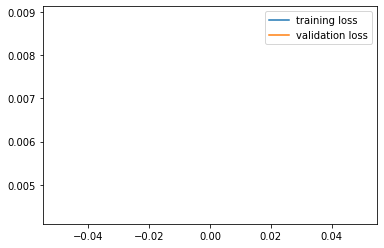

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.154280
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.117072
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.013249

Test set: Average loss: 0.0023, Accuracy: 5841/10000 (58%)



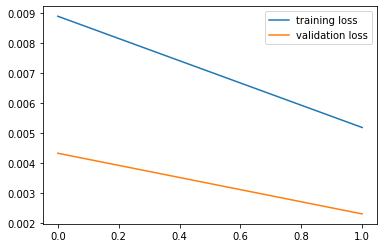

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.000659
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.887460
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.867471

Test set: Average loss: 0.0017, Accuracy: 6541/10000 (65%)



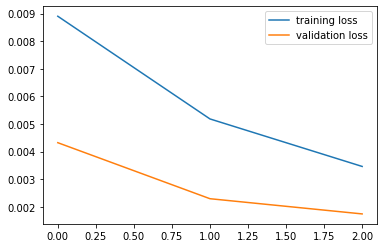

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.881217
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.809902
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.791494

Test set: Average loss: 0.0017, Accuracy: 6808/10000 (68%)



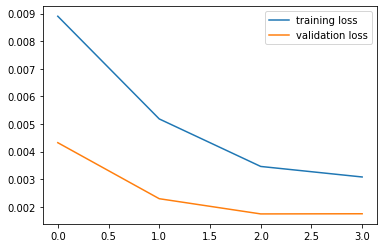

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.923775
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.710533
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.754055

Test set: Average loss: 0.0015, Accuracy: 7178/10000 (72%)



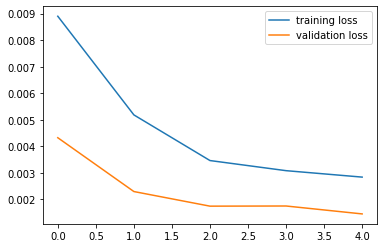

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.686902
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.676019
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.664444

Test set: Average loss: 0.0015, Accuracy: 7163/10000 (72%)



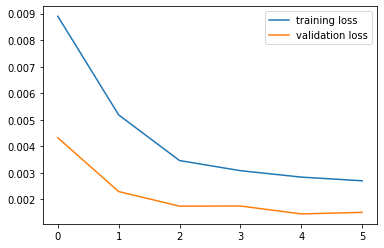

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.828066
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.767370
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.710790

Test set: Average loss: 0.0013, Accuracy: 7489/10000 (75%)



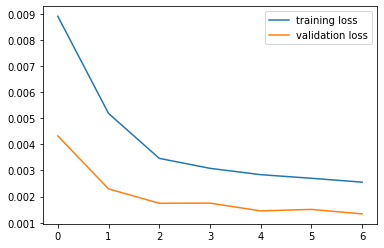

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.624180
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.535111
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.608914

Test set: Average loss: 0.0013, Accuracy: 7579/10000 (76%)



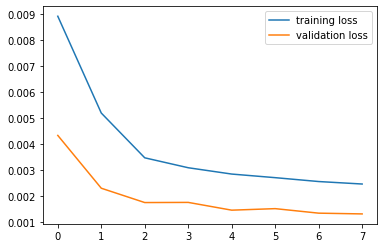

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.647908
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.575289
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.611050

Test set: Average loss: 0.0012, Accuracy: 7693/10000 (77%)



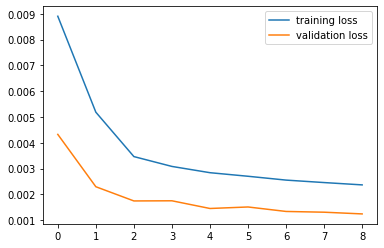

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.644583
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.613705
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.476832

Test set: Average loss: 0.0013, Accuracy: 7738/10000 (77%)



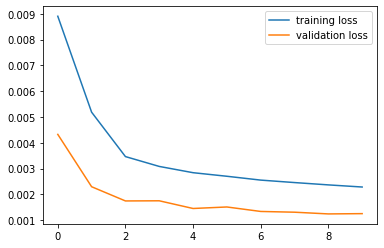

In [9]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss, _  = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

It may also be useful to visualize some qualitative examples of classification 

Correctly predicted: 78.7109375%


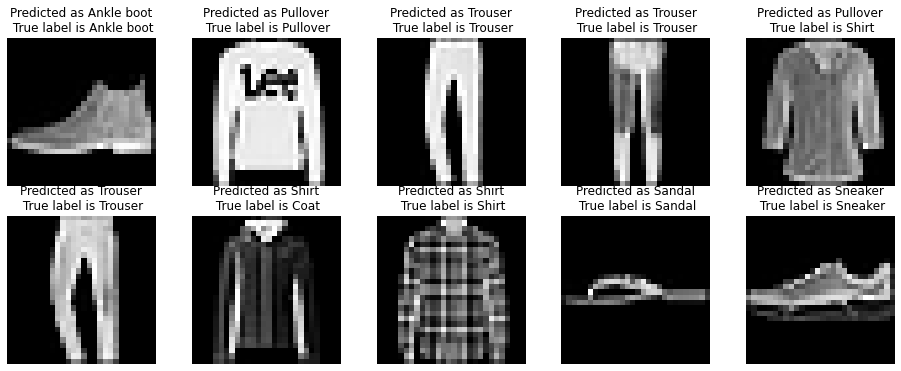

In [10]:
with torch.no_grad():

    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    
    print("Correctly predicted: {}%".format(100*sum(p == t for p, t in zip(predictions, true))/len(predictions)) )

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(val_set.classes[predictions[i]], val_set.classes[true[i]], ))

<br>
<span style="color:blue">
    
**Exercise 4**: Now repeat the same process, but flip the images horizontally before you run them through the model. Is your accuracy affected? Why?

>Hint: Check the `numpy.flip()` function

</span>

L'altra opció en lloc de fer servir torch.flip() és utilitzar Transforms. Per rotar horitzontalment les imatges fariem servir **RandomHorizontalFLip**, en cas de voler rotar totes les imatges ho indicaríem amb el paràmetre **p=1**. És a dir, rota amb una probabilitat del 100% totes les imatges. Quedaria així:

In [11]:
transforms_train = [
                    transforms.ToTensor(), 
                    transforms.RandomHorizontalFlip(p=1) # prob 1, en cada epoch el 100% de les imatges estàn horitzontalment rotades
                  ]

Si no volem fer ús de Transforms, també podem fer servir *torch.flip()*. Llegint la documentació veiem que aquest mètode accepta dos paràmetres, el *tensor input* i la dimensió en la qual volem girar el tensor (la dada), en aquest cas serà la tercera dimensió per fer una rotació horitzontal. Ho farem per totes les dades d'entrenament, mai en les de validació.

In [12]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))


    return val_loss, accuracy


def train(epoch, criterion, model, optimizer, loader, rotate = False):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        # Horizontal flip
        if rotate:
            assert data.dim() == 4, "Necesitem 4 dimensions [B,C,H,W] per flipar l'imatge"
            data = torch.flip(data, [3,])  # flipar horitzontalment
        
        data, target = data.to(device), target.to(device)   # enviem a GPU
  
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311179
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.286285
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.248891

Test set: Average loss: 0.0044, Accuracy: 2428/10000 (24%)



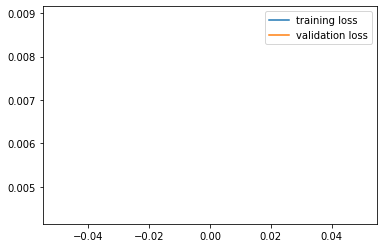

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.196986
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.422091
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.102172

Test set: Average loss: 0.0020, Accuracy: 6390/10000 (64%)



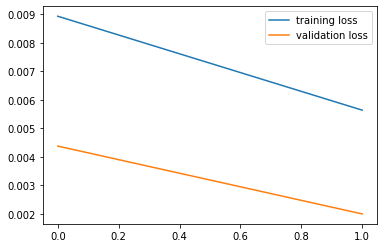

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.020476
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.787359
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.826956

Test set: Average loss: 0.0016, Accuracy: 6952/10000 (70%)



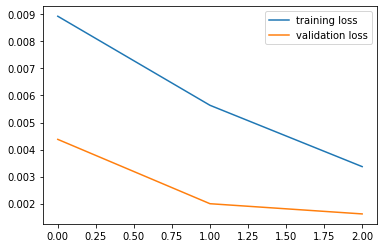

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.751892
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.765320
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.751274

Test set: Average loss: 0.0016, Accuracy: 6983/10000 (70%)



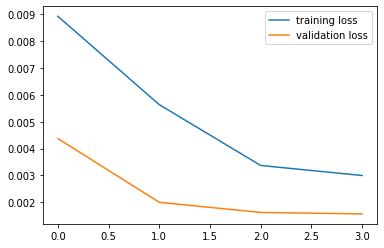

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.850463
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.676789
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.689488

Test set: Average loss: 0.0016, Accuracy: 7144/10000 (71%)



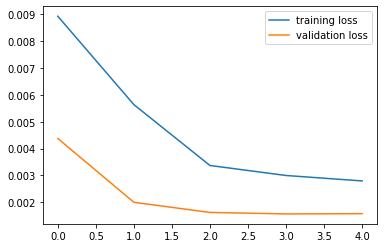

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.753262
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.728871
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.600894

Test set: Average loss: 0.0014, Accuracy: 7359/10000 (74%)



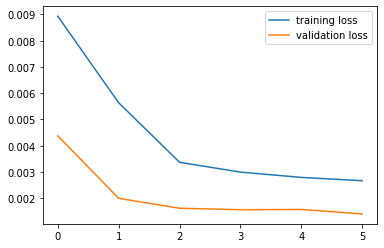

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.631946
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.629244
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.686680

Test set: Average loss: 0.0016, Accuracy: 7076/10000 (71%)



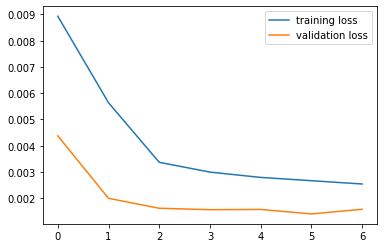

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.846295
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.590008
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.617793

Test set: Average loss: 0.0012, Accuracy: 7632/10000 (76%)



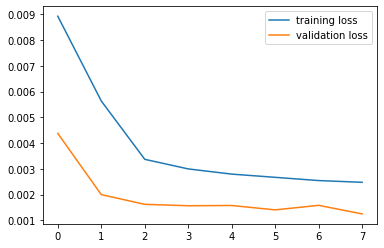

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.619879
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.702677
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.631346

Test set: Average loss: 0.0013, Accuracy: 7550/10000 (76%)



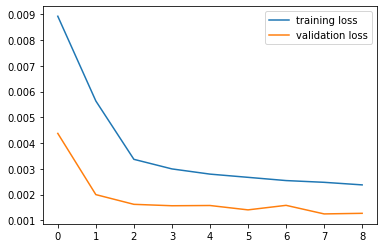

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.653401
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.546687
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.578077

Test set: Average loss: 0.0013, Accuracy: 7583/10000 (76%)



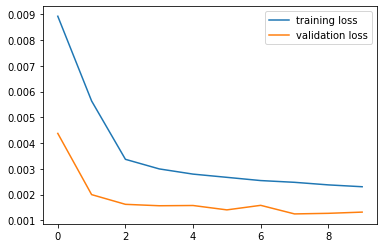

In [13]:
# Model CNN
model = CNN(6, output_size).to(device)

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2)

losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader, rotate = True)
    # cridem a la funció validate que rota horitzontalment les imatges
    val_loss, _  = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

L'*accuracy* pràcticament no canvia, això ens demostrà que les arquitectures CNN **són invariants a translació**, però **no són invariants a rotació**.

## Visualising Filters

One thing that would be interesting to visualise is the weights of the filters. To do so, we just need to access the weights of the convolutional layer of interest, and turn them into images. Here's an example for the first convolutional layer.

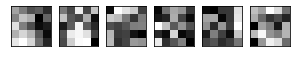

In [14]:
weight = model.conv1.weight.data.cpu().numpy()

# Display the filters
fig, ax = plt.subplots(1, weight.shape[0], figsize=(5, 5))

for i in range(weight.shape[0]):
    ax[i].imshow(weight[i, 0], cmap='gray') # show the first (and only) channel weights
    ax[i].axes.get_xaxis().set_visible(False)        
    ax[i].axes.get_yaxis().set_visible(False)

> Els filtres que hem definit (6 filtres de 5*5).

## Visualising Activation Maps

Another thing would be to visualise the activations of a convolutional layer for a specific image when it goes through the model. To do so, we need to somehow capture the output of the convolutional layer during the forward pass. This can be done with the function `nn.Conv2d.register_forward_hook()`. This function accepts as argument a callback function that will be called by the model when the forward pass takes place.

See some more information about this function below:

In [15]:
nn.Conv2d.register_forward_hook??

To try this out, we will defineby hand a toy model that does edge detection, as well as a couple of images to apply it on

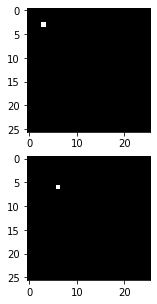

In [16]:
simpleEdgeDetector = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3)

# Define a vertical edge detector filter
simpleEdgeDetector.weight.data[0, 0] = torch.tensor([  [1., 0., -1.],
                                                   [1., 0., -1.],
                                                   [1., 0., -1.]])

# Define an horizontal edge detector filter
simpleEdgeDetector.weight.data[1, 0] = torch.tensor([  [1., 1., 1.],
                                                   [0., 0., 0.],
                                                   [-1., -1., -1.]])

simpleEdgeDetector.bias.data = torch.zeros(2)

simpleEdgeDetector = simpleEdgeDetector.to(device)


fakeImageBatch = torch.zeros(2, 1, 26, 26) # create a batch of two black images of (10, 10)
fakeImageBatch[0,0,3,3] = 1 # Paint white pixel (3, 3)
fakeImageBatch[1,0,6,6] = 1 # Paint white pixel (6, 6)

# Show the images
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].imshow(fakeImageBatch[0,0], cmap='gray')
ax[1].imshow(fakeImageBatch[1,0], cmap='gray')

> Implementem un *edge detector* molt senzill. En aquest cas *kernels* predefinits en el moment que tornen un *edge vertical o horitzontal* ens retornen una resposta més alta. Creem dues imatges ximples (tot negres amb un píxel blanc), les utilitzarem per provar si el *edge detector* funciona.

Let's also define some helper functions to plot a grid of activation maps given the output of a convolution layer.

In [17]:
def showImage(img, ax):
    # convert the tensor to numpy
    out = img.numpy()
    # Bring to the 0-255 range
    out = out - out.min()
    out = out / out.max()
    out = out * 255
    out = out.astype('uint8')
    # Plot image
    ax.axes.get_xaxis().set_visible(False)        
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(out, cmap='gray')

def showConvMap(conv_map):
    # Create a grid of images
    h = conv_map.shape[0] # = number of images in the batch
    w = conv_map.shape[1] # = number of activation maps per image
    fig, ax = plt.subplots(h, w, figsize=(10, 10))

    # Plot activation maps
    for i in range(conv_map.shape[0]):
        for j in range(conv_map.shape[1]):
            showImage(conv_map[i][j], ax[i, j])
    
    fig.tight_layout()

Now we can define our hook function, which just calls `showConvMap()` to plot the output activation maps for all the images of our batch and all the filters of this layer.

Output shape: torch.Size([2, 2, 24, 24])


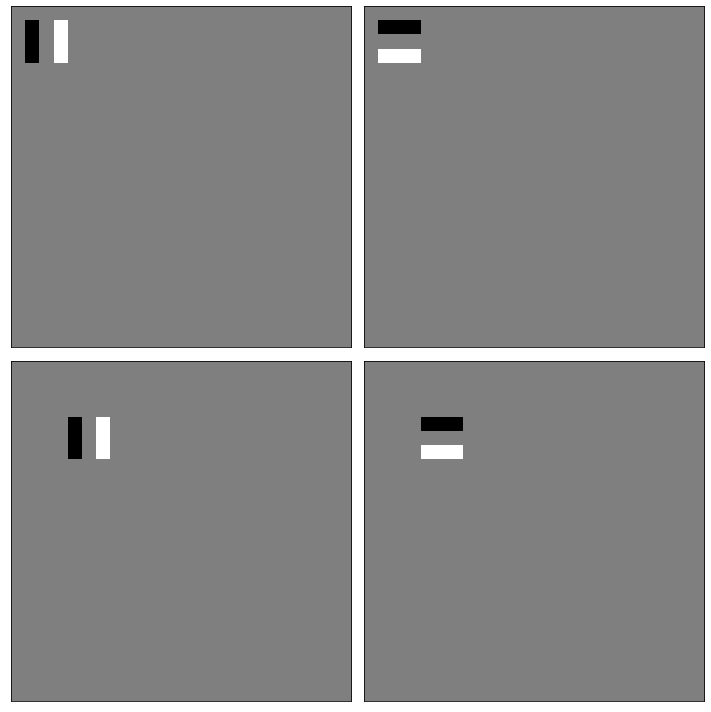

In [18]:
def hook_ShowOutput(module, input, output): # Sempre tenen aquesta interficie
    print("Output shape:", output.shape)
    showConvMap(output.cpu())               

fakeImageBatch = fakeImageBatch.to(device)

with torch.no_grad():
    handle = simpleEdgeDetector.register_forward_hook(hook_ShowOutput) # cada vegada que fem forward pas a la capa crides a aquella funció.
    embed = simpleEdgeDetector(fakeImageBatch)
    handle.remove()

> Quan posem les imatges fake ens crea aquest plto. per cada imatge hi han dos filtres, cada un es 24x24. 

> INicialment eren de 26x26 i el kernel es 3 per aixo surt 24. la resposta del edge detector es que detecta el pixel en la primera imatge i tmb en la segona.

<br>
<span style="color:blue">
    
**Exercise 5**: Visualize the feature (activation) maps of the first and last convolutional layers of our CNN model for 10 images of your validation set. Use the code provided before as the basis for your visualisation. What conclusions can you draw?
    
</span>

In [19]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 10, shuffle=False, num_workers=2)

Output shape: torch.Size([10, 6, 24, 24])


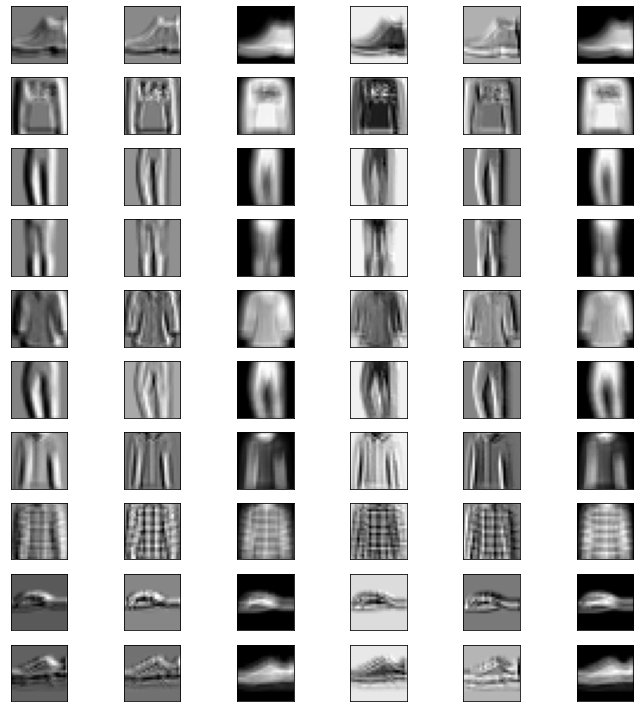

In [20]:
with torch.no_grad():
    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)
    handle = model.conv1.register_forward_hook(hook_ShowOutput)
    output = model(data)
    handle.remove()

De la iamtge superior veiem que cada columna és una neurona, en ser la primera capa veiem que les *features* que es detecten són de molt baix nivell (primeres i segones derivades), molt senzilles. Veiem per exemple que en la majoria d'imatges que són pantalons detectem *edges* verticals. Això també ho veiem per algunes camisetes.

En resum, veiem que aquesta primera capa detecta característiques molt senzilles, sense aprofundir en els detalls de l'objecte intentar classificar-lo (un detall podria ser els botons d'una camisa per exemple).

Output shape: torch.Size([10, 6, 8, 8])


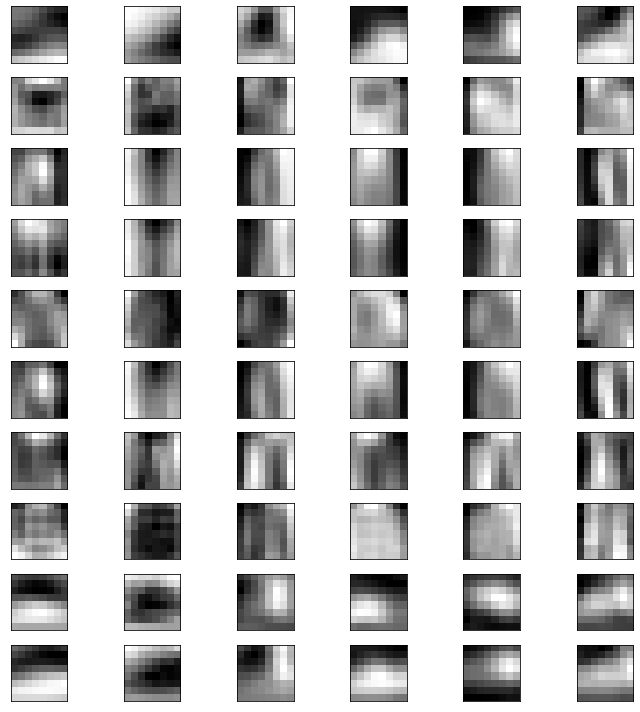

In [21]:
with torch.no_grad():
    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)
    handle = model.conv2.register_forward_hook(hook_ShowOutput)
    output = model(data)
    handle.remove()

En aquesta última capa veiem que la xarxa es fixa en coses de més alt nivell de l'objecte, ja no busca *edges* verticals/horitzontals sinó característiques més abstractes. A la fi, el cervell humà per reconèixer una cara no té prou amb mirar un ull, s'ha de mirar un conjunt de detalls/característiques per a saber de quina persona parlem. Aquests detalls de l'objecte les troba la xarxa (sense nosaltres dir-li quines són).

També notem que els píxels són més grans, això és pel fet que en cada *maxpool* agafa el màxim de la regió anterior, tenint cada cop menys dades. Aquest pas el fem per fer invariància d'*allocation*.